In [1]:
import sympy as sy
import numpy as np
import cvxpy as cp
from MyTransformers import *
import math

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

In [2]:
def fShow(batChange,cons,prod,plot=True):
    l = len(prod)
    Pgrid = [0]*l
    eBalAbs = [0]*l
    bat = [0]*l
    eba = 0;b = 0
    bal = cons - prod
    for i in range(l):
        Pgrid[i] = (bal[i] + batChange[i])
        eba += abs(Pgrid[i])
        eBalAbs[i] = eba
        b += batChange[i]
        bat[i] = b
    #print(eBalAbs[-1])
    if plot:
        plt.plot(eBalAbs,label="eBalAbs")
        plt.legend(fontsize=10, loc="upper left")
        plt.figure()

        plt.plot(Pgrid,label="Pgrid")
        plt.plot(bat,label="bat")
        plt.plot(batChange,label="batChange")
        plt.legend(fontsize=10, loc="upper left")
    return eBalAbs[-1]

def fCostShow(batChange,cons,prod,chargeCoef,plot=True):
    l = len(prod)
    Pgrid = [0]*l
    bat = [0]*(l+1)
    cost = [0]*(l + 1)
    costVal = [0]*l
    bal = cons - prod

    for i in range(l):
        Pgrid[i] = bal[i] + batChange[i]
        if Pgrid[i] < 0:
            Pgrid[i] *= energySellCoef
        costVal[i] = energyCost(i)*Pgrid[i]/granulity*agregAmount
        cost[i+1] = cost[i] + costVal[i]
        if batChange[i] > 0:
            bat[i+1] = bat[i] + batChange[i] * chargeCoef
        else:
            bat[i+1] = bat[i] + batChange[i]

    #print(cost[-1])
    if plot:
        plt.plot(cost,label="cost Sum")
        plt.plot(costVal,label="cost Val")
        plt.legend(fontsize=10, loc="upper left")
        plt.figure()
        
        plt.plot(Pgrid,label="Pgrid")
        plt.plot(bat,label="bat")
        plt.plot(batChange,label="batChange")
        plt.legend(fontsize=10, loc="upper left")
    return cost[-1]
    
def generate(granulity, lenght, plot=False):
    l1 = int(lenght * granulity)
    cons1 = np.maximum(np.sin(np.arange(l1)/granulity) + np.sin(np.arange(l1) / 5 /granulity)*3.5 + np.random.rand(l1)*3,0)
    prod1 = np.maximum(np.sin(np.arange(l1)/granulity)/1.2 + np.sin(np.arange(l1) / 5 /granulity)*2.8 + np.random.rand(l1) + np.sin(np.arange(l1) / 6 /granulity + 2)*1.8 ,0)
    cons1 /= granulity
    prod1 /= granulity
    if plot:
        plt.plot(cons1)
        plt.plot(prod1)
        plt.plot(prod1-cons1)
        plt.legend(["cons","prod","prod-cons"])
        plt.grid(True, which='both')
        plt.figure()
    return cons1, prod1

def batch(agregAmount, cons1, prod1, plot=False):
    l = len(cons1) - len(cons1)%agregAmount
    cons = cons1[:l]
    cons = np.sum(cons.reshape(-1,agregAmount),axis=1)
    prod = prod1[:l]
    prod = np.sum(prod.reshape(-1,agregAmount),axis=1)
    if plot:
        plt.plot(cons)
        plt.plot(prod)
        plt.plot(prod-cons)
    return cons,prod

## Generate

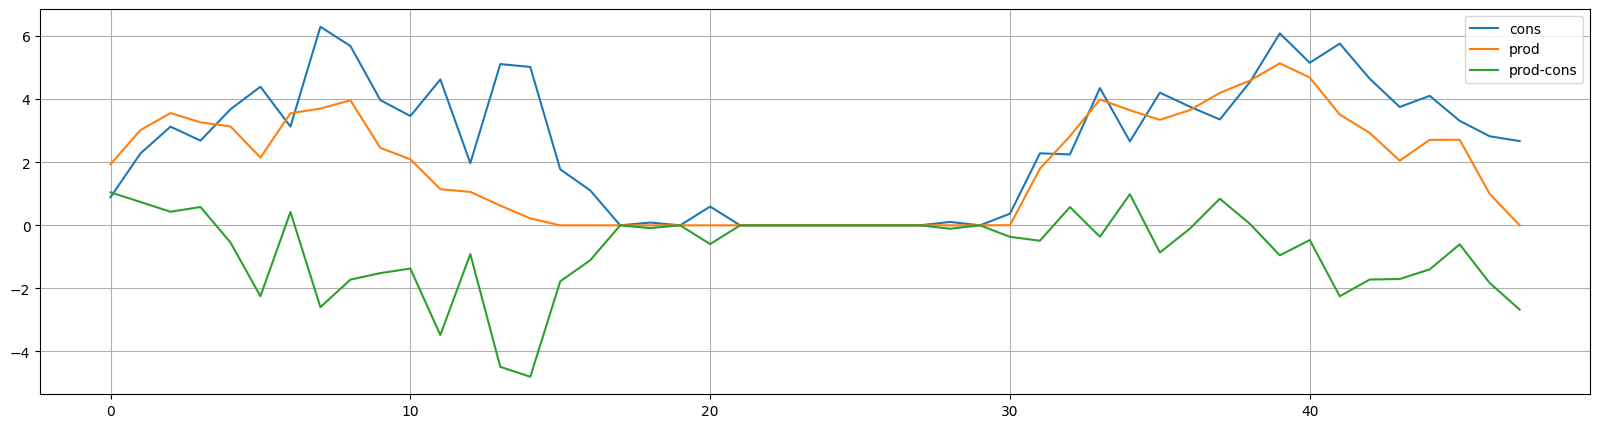

<Figure size 2000x500 with 0 Axes>

In [3]:
interval = 60 # in mins
lenght = 48 # lenght in hours
granulity = 60 / interval# per hour
batInit = 0
xx = []

cons1, prod1 = generate(granulity,lenght,plot=True)

#### GenTests

Text(0.5, 1.0, 'nadwyzki produkcji')

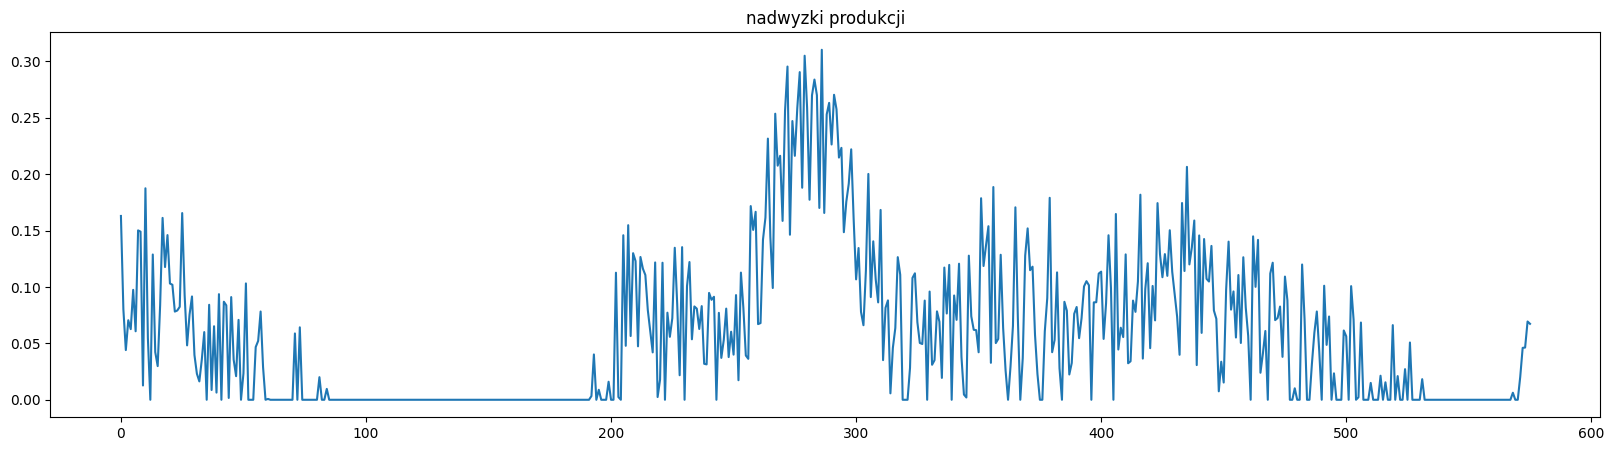

In [29]:
plt.plot(np.maximum(prod1-cons1,0))
plt.title("nadwyzki produkcji")

Text(0.5, 1.0, 'zapotrzwbowanie na prąd')

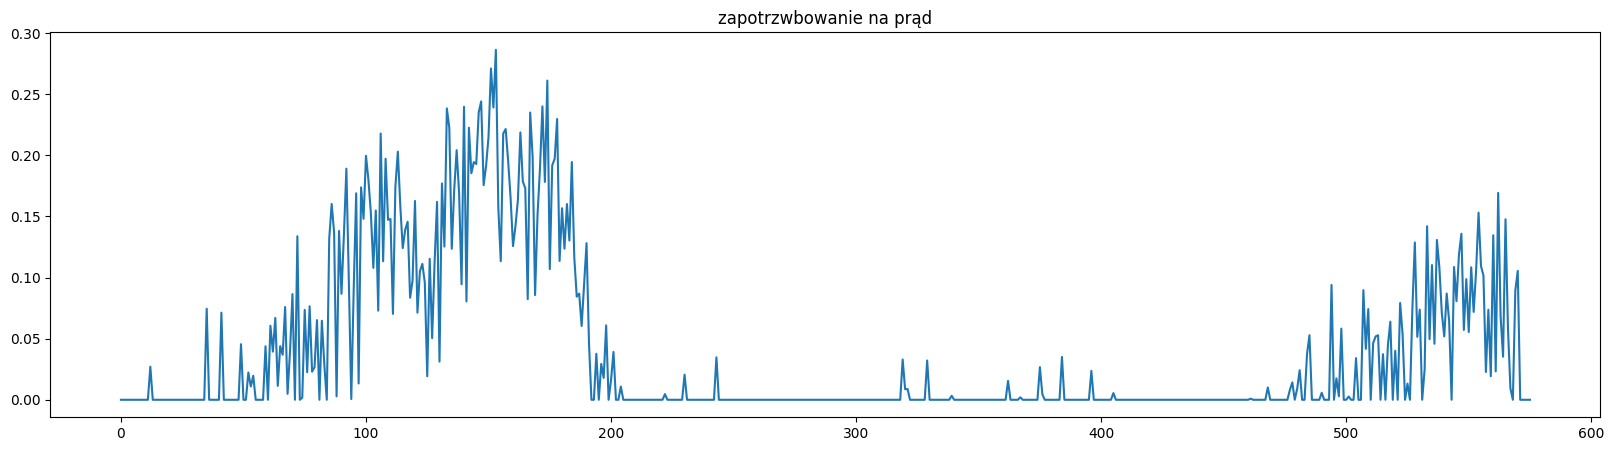

In [30]:
plt.plot(np.maximum(cons1-prod1,0))
plt.title("zapotrzwbowanie na prąd")

#### Opisy podejśc do optymalizacji

In [5]:
def UseBatEffi(chargeEffi,dischargeEffi, powerLossOverTime, t):
    return chargeEffi * dischargeEffi # - powerLossOverTime * t

'''
    na przewidziane zuzycie w high przechować prąd w poprzez dociągnąć z sieci prad zeby starczylo na zapotrzbowanie w high
'''
def CheckFilBatFromGridForLaterComsumption(useBatEffi, highPrice, lowPrice):
    costOf1kWhBothDuringLowUseInHight = 1 / useBatEffi * lowPrice # 1/useBatEffi - how much kwh is needed in battery for 1 kwh taken from battery at hight
    return costOf1kWhBothDuringLowUseInHight < highPrice


'''
    na przewidziane zuzycie w high przechować prąd w poprzez dociągnąć z sieci prad zeby starczylo na zapotrzbowanie w high
'''
def CheckFilBatFromGridForLaterComsumption(useBatEffi, highPrice, lowPrice):
    costOf1kWhBothDuringLowUseInHight = 1 / useBatEffi * lowPrice # 1/useBatEffi - how much kwh is needed in battery for 1 kwh taken from battery at hight
    return costOf1kWhBothDuringLowUseInHight < highPrice

''' 
    pomimo pustej prezstrzeniu w baterri, nałądować w low zeby sprzedac w high:
    sprawdzenie czy sie taka strategia opłaca.
    - jeśli jest puste miejsce w pojemnosći bateri na przewidziane zużycie prądu
'''
def CheckStoreInBatteryOrSellAtNight(useBatEffi, highPrice, lowPrice):
    costOf1kWhBothDuringLowUseInHight = 1 / useBatEffi * lowPrice # 1/useBatEffi - how much kwh is needed in battery for 1 kwh taken from battery at hight
    return costOf1kWhBothDuringLowUseInHight < highPrice

'''only overflow to sell or keep'''
def CostStoreHigh(useBatEffi, highPrice, lowPrice):
    pass

'''assumes you store all power and buy from grid'''
def CostStoreAllForHighBuyLowEnergy(useBatEffi, highPrice, lowPrice):
    return ((1 - useBatEffi)*highPrice + lowPrice)    

'''assumes you store all power and buy from grid'''
def CostStoreAllForHighBuyLowEnergy_UseBuyHigh(useBatEffi, highPrice, lowPrice):
    return ((1 - useBatEffi)*highPrice + lowPrice) - (highPrice) # effi * h > l

In [4]:
# powerProduction = 1 # chwilowe
# powerConsumption = 1 # chwilowe
# battChargeEffi = 0.9
# battDischargeEffi = 0.9
# battMaxPowerInput = 1
# battMaxPowerOutput = 1
# lowPrice = 0.8
# highPrice = 1
# sellPrice = 0.6
# batteryPowerStored = 1
# batteryPowerStoredMax = 5

#przewidziane zapotrzebowanie energii w high (zapotrzebowanie - produkcja) cala produkcja idzie w zapotrzebowanie nima nic lepszego, to nas informuje ile powinno być w baterii 
# pytanie jaką cześć tego z baterri a jaką z sieci
#🤞 0zapisywać pytania 🤞
nazwa = 1
# optymalizacja naladowania baterii 
# moze nie starczyć czasu zeby nałądować z maksymalnym pradem ladowania i trzeba zaczac wcześniej 

batUseEffi = UseBatEffi(battChargeEffi, battDischargeEffi, 0,0)

def takeFromBattery():pass
def chargeBatterry(): pass
def takeFromGrid(): pass
def sellToGrid(): pass

if powerProduction > powerConsumption: # exces power production
    powerOverFlow = powerProduction - powerConsumption
    # check for storing power for high
    if CheckForSellPrice():# nie opłaca sie trzymać pradu
        sellToGrid(powerOverFlow)
    else: # charge battery
        if powerOverFlow > battMaxPowerInput: # if to much power for charing
            chargeBatterry(battMaxPowerInput)
            sellToGrid(powerOverFlow - battMaxPowerInput)
        else: # can charge all 
            chargeBatterry(powerOverFlow)
else: # Power is needed 
    powerNeeded = powerConsumption - powerProduction
    if powerNeeded < battMaxPowerOutput: #  enougth power output
        if powerNeeded < batteryPowerStored: # enougth power in battery
            takeFromBattery(powerNeeded)
        else: # not enougth power in batter
            #take all power from battery and rest from grid
            takeFromBattery(batteryPowerStored)
            takeFromGrid(powerNeeded - batteryPowerStored)
    else: # not enougth power output
        takeFromBattery(battMaxPowerOutput)
        takeFromGrid(powerNeeded - battMaxPowerOutput)

if batteryPowerStored < batteryPowerStoredMax:
    if CheckStoreInBatteryOrSellAtNight(batUseEffi,highPrice, lowPrice): # if cost effectif is to strore power from low to high
        takeFromGrid()

NameError: name 'UseBatEffi' is not defined

In [ ]:
'''
Nie mia nic bardziej oplacalnego niz zuzycie pradu jaki jest produkowany na aktualne zapotrzebowanie( warunek ktory jest zawsze true priceSell < priveLow) 
zuzycie trzeba zawsze pokryc, wiec w najgprszym przypadku sprzedajemy po cenie sell jak jest wieksza niez cena low bo wtedy można by sprzedac teraz a kupic w low zeby miec na zapotrzebowanie
'''
'''
ekentywność łądowania zależna od stanu nałądowania baterii, 
[założenie] efektywność ładowania nie lazey od weiku baterri
[założenie] effi bat nie zalezy od temperatury bat
[założenie] prad lądowania jest stały
'''
'''
[założenie] predykcja zużycia jak i produkcji jest w 100% celna
'''
#Krok 1 Obliczenie jaki zostaje nam nadmiar albo nie domiar mocy do zagospodarowania
powerOverFlow = np.maximum(predPowerIn['value']  - predPowerOut['value'], 0) # wszysztkie pozytywne wartosci  
powerRequired = np.maximum(predPowerOut['value'] - predPowerIn['value'], 0) # wszysztkie pozytywne wartosci  

#krok 2 identyfikacja zapotrezbowan miedzy streafmi low a high 
powerOverFlowLow  = [ powerOverFlow['value'][i] for t,i in enumerate(powerOverFlow['time']) if IsTimeLow(t)]
powerOverFlowHigh = [ powerOverFlow['value'][i] for t,i in enumerate(powerOverFlow['time']) if IsTimeHigh(t)]
powerRequiredLow  = [ powerRequired['value'][i] for t,i in enumerate(powerRequired['time']) if IsTimeLow(t)]
powerRequiredHigh = [ powerRequired['value'][i] for t,i in enumerate(powerRequired['time']) if IsTimeHigh(t)]

#krok 3 naivnie ladowac batterie wtedy kiedy mamy prad, brać z bateri jak mamy w high, reszta co została bierzemy w low,

#batpower cumulate if in low batpower use in high
for t,i in enumerate(powerOverFlow['time']) :
    power = powerOverFlow['value'][i]
    powerLeft = battery.charge(power,timeInterval)
    sellToGrid(powerLeft)
    '''
    przypadek gdy ladowanie jest natyle stratne ze oplaca sie sprzedac a nie łądowac dalej
    '''


#### Algo Optymalizacji wersja wląsan

In [9]:
class Battery:
    chargeCurrent = 0
    chargeMax = 1
    effiLen = 10
    effiIn = []     # should be of len effiLen, wyrazone w wartość zaleznej od procentu naladowania 
    effiOut = []    # should be of len effiLen


    currenMaxIn = 1     #ampery
    voltMaxIn = 30      #volt
    voltMaxOut = 24     #volt
    currenMaxOut = 1    #ampery
    powerInMax = 1      # w kWh
    powerOutMax = 1     # w kWh

    def __init__(self, _chargeCurrent, _charegeMax, _effiIn, _effiOut, currentMaxIn, currentMaxOut, voltIn, voltOut) -> None:
        self.chargeCurrent = _chargeCurrent
        self.chargeMax = _charegeMax
        if type(_effiIn) == list:
            self.effiLen = len(_effiIn)
            self.effiIn = _effiIn
        else:
            for i in range(self.effiLen):
                self.effiIn.append(_effiIn)
        
        if type(_effiOut) == list:
            if len(_effiOut) != self.effiLen:
                print("[Error] size of effiIn is not equal to size of effiOut")
            self.effiOut = _effiOut
        else:
            self.effiOut = []
            for i in range(self.effiLen):
                self.effiOut.append(_effiOut)

        self.currenMaxIn = currentMaxIn
        self.voltMaxIn = voltIn 
        self.powerInMax = currentMaxIn * voltIn

        self.currenMaxOut = currentMaxOut
        self.voltMaxOut = voltOut 
        self.powerOutMax = currentMaxOut * voltOut

    '''
    zależne od satnu baterii
    '''
    def effi(self):
        index = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        return self.effiIn[index] * self.effiOut[index]
    
    def effiIN(self):
        index = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        return self.effiIn[index]
    
    def effiOUT(self):
        index = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        return self.effiIn[index]
    
    def powerRequiredToGetToLVL(self, lvl): 
        return self.powerRequiredToGetToLVLFrom(self.chargeCurrent,lvl)
    
    def powerRequiredToGetToLVLFrom(self,startLvl, lvl): 
        if lvl > self.chargeMax:
            print("[error] lvl higher then max lvl")
            lvl = self.chargeMax
        sum = 0
        charge = startLvl
        targetIndex = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        currIndex = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        maxCapPerIndex = []
        for i in range(self.effiLen):
            maxCapPerIndex.append(self.chargeMax * ((i + 1)/self.effiLen))

        while currIndex <= targetIndex:
            powerInIndex = maxCapPerIndex[currIndex]-charge
            actualPower = powerInIndex / self.effiIn[currIndex]
            charge += powerInIndex
            sum += actualPower
            currIndex += 1
        
        currIndex = min(currIndex, self.effiLen-1)
        powerInIndex = lvl-charge
        actualPower = powerInIndex / self.effiIn[currIndex]
        charge += powerInIndex
        sum += actualPower
        return sum
    
    # [zalożęnie] all power is in max powerIn limit
    # returns charge state after, and power left
    def powerChargedFromPower(self, lvl): 

        charge = self.chargeCurrent
        currIndex = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        maxCapPerIndex = []
        for i in range(self.effiLen):
            maxCapPerIndex.append(self.chargeMax * ((i + 1)/self.effiLen))
        #print(maxCapPerIndex)
        while lvl > 0:
            powerInIndex = maxCapPerIndex[currIndex]-charge
            actualPower = min(powerInIndex / self.effiIn[currIndex],lvl)
            powerInIndex = actualPower * self.effiIn[currIndex]
            #print("i:",currIndex,"powInInd:", powerInIndex,"actualP:", actualPower,"charg:",charge,"lvl:",lvl)
            if charge + powerInIndex < self.chargeMax:
                charge += powerInIndex
                lvl -= actualPower
            else:
                capLeft = self.chargeMax - charge
                lvl -= capLeft / self.effiIn[currIndex]
                charge = self.chargeMax
                break
            currIndex += 1
        
        return (charge, lvl)

    # returns (power drained from battery, actual power given)
    def powerDrainedToGetPower(self, lvl):
        # if lvl > self.chargeCurrent:
        #     print("[error] lvl higher then current charge")
        sum = 0
        charge = self.chargeCurrent
        currIndex = min(math.floor(self.chargeCurrent / self.chargeMax * (self.effiLen)),self.effiLen-1)
        maxCapPerIndex = [0]
        for i in range(self.effiLen):
            maxCapPerIndex.append(self.chargeMax * ((i + 1)/self.effiLen))
        #print(maxCapPerIndex)
        while sum < lvl and charge > 0:
            powerInSegment = charge - maxCapPerIndex[currIndex]
            #print(currIndex, sum, charge, powerInSegment)
            if sum + powerInSegment*self.effiOut[currIndex] < lvl:
                charge -= powerInSegment
                sum += powerInSegment*self.effiOut[currIndex]
            else:
                diff = lvl - sum
                charge -= diff / self.effiOut[currIndex]
                sum = lvl
            currIndex -= 1
        return (self.chargeCurrent - charge, sum)


    #[założenie] effi zawsze maleje wraz z poziomem naladownia
    # returns % of charge
    def maxProfitChargeLvl(self, money):
        for i in reversed(range(self.effiLen)):
            #print(self.effiLen, i)
            if 1/ (self.effiIn[i] * self.effiOut[i]) * money.getLowestSellPrice() < money.getHighestSellPrice():
               #print(i+1,self.effiIn[i] ,self.effiOut[i],self.effiIn[i] * self.effiOut[i],1/ (self.effiIn[i] * self.effiOut[i]),1/ (self.effiIn[i] * self.effiOut[i]) * money.getLowestSellPrice(),money.getHighestSellPrice(),money.getLowestSellPrice())
               return (i+1) / self.effiLen
               #return 0.8
        return 0
    '''
    returns power left after max charge
    [założenie] wartosć mocy jaką łąduje jest na timeInterval i maksymalna moca w tym okresie jest uśredniona wartosć
    [założenie] da sie dowolnie streoawc moca z paneli (np w danym momencie 50% idzie na baterie a 50% do sieci )
    '''
    def charge(self, powerIn, timeInterval):
        if powerIn < 0: 
            print("[Error], charging negative power")
            return
        maxValue = powerIn / timeInterval
        if self.powerInMax >= maxValue: 
        #     # peek mocy ladowania jest w zakresie
        #     powerUsed = powerIn
        #     powerAfterCharged = min(self.chargeMax, self.chargeCurrent + powerIn)
            (charge, powerleft) = self.powerChargedFromPower(powerIn)
        else:
            powerAfterCharged = self.powerInMax * timeInterval # check for max that can go in in this interval 
        #     powerAfterCharged = min(self.chargeMax, self.chargeCurrent + powerAfterCharged)    # check for max capacity
            (charge, powerleft) = self.powerChargedFromPower(powerAfterCharged)
            powerleft += powerIn - powerAfterCharged
        
        self.chargeCurrent = charge
        # powerLeft = powerIn - (powerAfterCharged - self.chargeCurrent)
        # self.chargeCurrent = powerAfterCharged
        return powerleft

    '''
    return power that cant be obtaionded from battery
    '''
    def discharge(self, powerOut, timeInterval):
        if powerOut < 0: 
            print("[Error], discharging negative power")
            return
        maxValue = powerOut / timeInterval
        if self.powerOutMax >= maxValue: 
            # peek poboru mocy jest w zakresie batteri
            # powerDischarged = min(self.chargeCurrent, powerOut)
            (powerUsed, powerGet) = self.powerDrainedToGetPower(powerOut)
        else:
            powerDischarged = self.powerOutMax * timeInterval # check for max that can go out in this interval 
            # powerDischarged = min(self.chargeCurrent, powerDischarged)    # check if power in batter exists
            (powerUsed, powerGet) = self.powerDrainedToGetPower(powerDischarged)

        
        self.chargeCurrent -= powerUsed
        return powerOut - powerGet
        # self.chargeCurrent -= powerDischarged
        # return powerOut - powerDischarged
    
    def useBattery(self,power, timeInterval):
        if power > 0: # charge 
            return self.charge(power,timeInterval)
        else:
            return -self.discharge(-power, timeInterval)
    
    def reset(self):
        self.chargeCurrent = 0

    def print(self):
        print(f"{self.chargeCurrent} / {self.chargeMax}; in:{self.powerInMax} out:{self.powerOutMax}; effi:{self.effi()}")

In [84]:
bat = Battery(0,100,[0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.6] ,0.9,1,10,30,1)
bat.maxProfitChargeLvl(money)

0.8

In [4]:
class Money:
    price = []
    priceOverLimit = []
    priceSell = []         # pln/ kWh 
    powerUsedThisYear = 0 #kWh
    powerPriceLimit = 2000 #kWh
    hoursLow = []
    # hoursHigh = [] # te godziny sa dopelnieniem 

    currMoney = 0 
    currSellBalance = 0

    startPowerUsedThisYear = 0
    startSellBalance = 0

    def __init__(self, price:list, priceOverLimit:list, hoursLow:list, priceSell:list, powerUsedThisYear, powerPriceLimit = 2000, sellBallance = 0):
        if(len(price) != 24):           print("price leght should be 24")
        if(len(priceOverLimit) != 24):  print("price leght should be 24")
        if(len(priceSell) != 24):       print("price leght should be 24")
        self.price = price
        self.priceOverLimit = priceOverLimit
        self.priceSell = priceSell
        self.powerUsedThisYear = powerUsedThisYear
        self.powerPriceLimit = powerPriceLimit
        self.hoursLow = hoursLow
        self.currSellBalance = sellBallance

        self.startPowerUsedThisYear = powerUsedThisYear
        self.startSellBalance = sellBallance

    def __init__(self, priceLow, priceHigh, priceOverLow, priceOverHigh, hoursLow:list, priceSell:list, powerUsedThisYear, powerPriceLimit = 2000):
        self.hoursLow = hoursLow
        self.priceSell = priceSell
        self.powerUsedThisYear = powerUsedThisYear
        self.powerPriceLimit = powerPriceLimit
        for i in range(1,25):   
            self.price.append(priceLow if self.IsTimeLow(i) else priceHigh)
            self.priceOverLimit.append(priceOverLow if self.IsTimeLow(i) else priceOverHigh)


    '''
    time in hours of day
    '''
    def getBuyPrice(self, time:int):
        if 1 > time > 24:
            print("time out of bounds")
            time = max(0,min(24,time))
        time -= 1
        if self.powerUsedThisYear > self.powerPriceLimit:
            return self.priceOverLimit[time]
        else:
            return self.price[time]
        
    '''
    time in hours of day
    '''
    def getSellPrice(self, time:int):
        if 1 > time > 24:
            print("time out of bounds [1,24]")
            time = max(0,min(24,time))
        time -= 1
        return self.priceSell[time]
    
    def getHighestSellPrice(self):
        return max(self.priceSell)
    
    def getLowestSellPrice(self):
        return min(self.priceSell)

    def IsTimeLow(self,time:int):
        if 1 > time > 24:
            print("time out of bounds [1,24]")
            time = max(0,min(24,time))
        return time in self.hoursLow

    def IsTimeHigh(self,time:int):
        return not self.IsTimeLow(time)

    def SellPower(self, power, time:int):
        if power < 0:
            print("cant sell negative power")
            return 
        price = self.getSellPrice(time)
        self.currSellBalance += price * power

#[założenie] jesteśmy staratni w 100% jak nie wykozystamy energi tej "sprzedanej"
    def BuyPower(self, power, time:int):
        if power < 0:
            print("cant buy negative power")
            return 
        price = self.getBuyPrice(time)
        moneyFromBalance = min(self.currSellBalance, price * power)
        self.currSellBalance -= moneyFromBalance
        power -= moneyFromBalance / price
        self.powerUsedThisYear += power # do limitu liczy sie tylko energia jaka jest kupiona z sieci, a energia co jest sprzedana i odebrana z sieci nie liczy sie jako eneragia kupiona https://www.farmer.pl/finanse/jak-bedzie-rozliczany-prad-z-fotowoltaiki-w-ramach-limitow-zamrazajacych-ceny-pradu,123939.html
        self.currMoney -= power*price

    def UseGrid(self, power,time:int):
        if power < 0:
            self.BuyPower(-power, time)
        else:
            self.SellPower(power,time)

    def reset(self):
        self.currMoney = 0
        self.currSellBalance = self.startSellBalance
        self.powerUsedThisYear = self.startPowerUsedThisYear

    def print(self):
        print(f"mon:{self.currMoney} bala:{self.currSellBalance} usag:{self.powerUsedThisYear}")

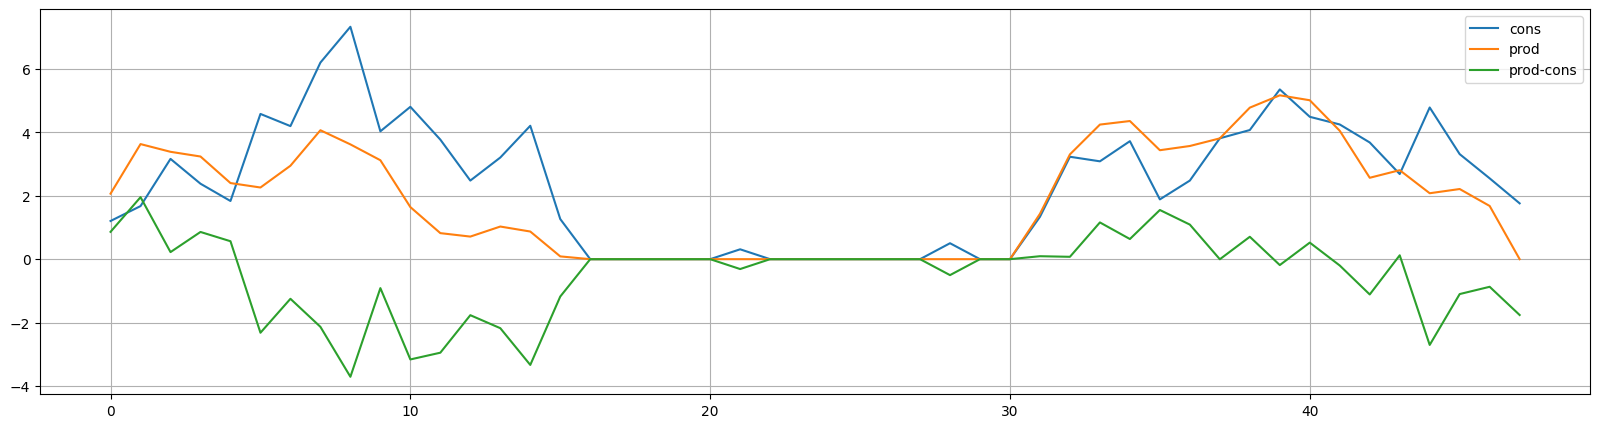

<Figure size 2000x500 with 0 Axes>

In [5]:
interval = 60 # in mins
lenght = 48 # lenght in hours
timeInterval = 60 / interval# per hour
batInit = 0
cons1, prod1 = generate(timeInterval,lenght,plot=True)

In [6]:
def plotPowerLines(**lines):
    for l in lines.values():
        plt.plot(l[0],l[1])
        if len(l) > 2:
            if l[2]:
                for i,j in zip(range(len(l[0])),l[0]):
                    plt.annotate(f'{j:.2f}',xy=(i,j))
                    
    plt.axhline(y = battery.chargeMax, color = 'purple', linestyle = '-')
    beginState = money.IsTimeLow(predPowerIn['time'][0])
    b = 0
    for i,t in enumerate(predPowerIn['time']):
        if beginState != money.IsTimeLow(t):
            beginState = not beginState
            plt.axvspan(b, i, facecolor='green' if not beginState else 'red', alpha=0.3)
            b = i

    
    plt.axvspan(b, len(predPowerIn['time'])-1, facecolor='green' if  beginState else 'red', alpha=0.3)
    plt.legend(lines.keys())
    plt.grid(True,which='both')
    plt.figure()

13.091776938491423
[38, 14, 5]
buy p:-1.7683400667531253, i:12
buy p:-2.178952644988968, i:13
buy p:-0.002909934357296251, i:37
12.829926969752545
[0, 1.7620136437495197, 0.20115233988547399, 0.7385427163231215, 0.45301562232747283, -2.580857973500598, -1.3503381934571723, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08415078796302436, 0.06743445168454709, 1.0441106579891704, 0.5725155576801502, 1.3973111258265802, 0.8770269785192042, -0.0032332603969962292, 0.5655598496211871, -0.20690226274424006, 0.41823205988935896, -0.22241238988624534, -1.2381176163724952, 0.09784641050575349, -3.0086909685640855, -0.44483138171491365, 0.0, 0.0]
0.9


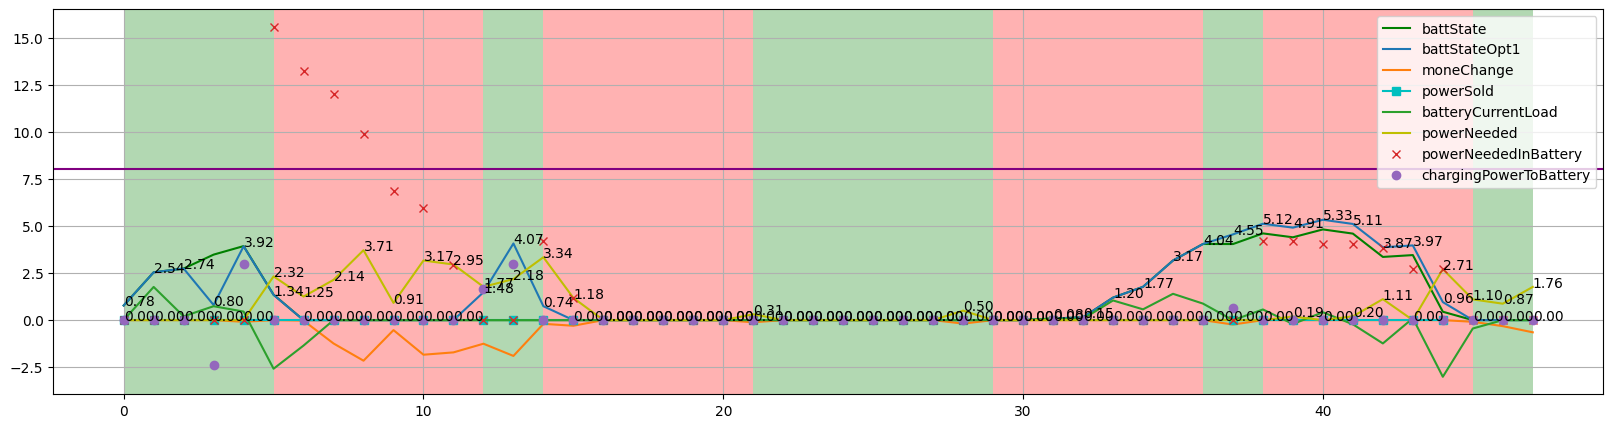

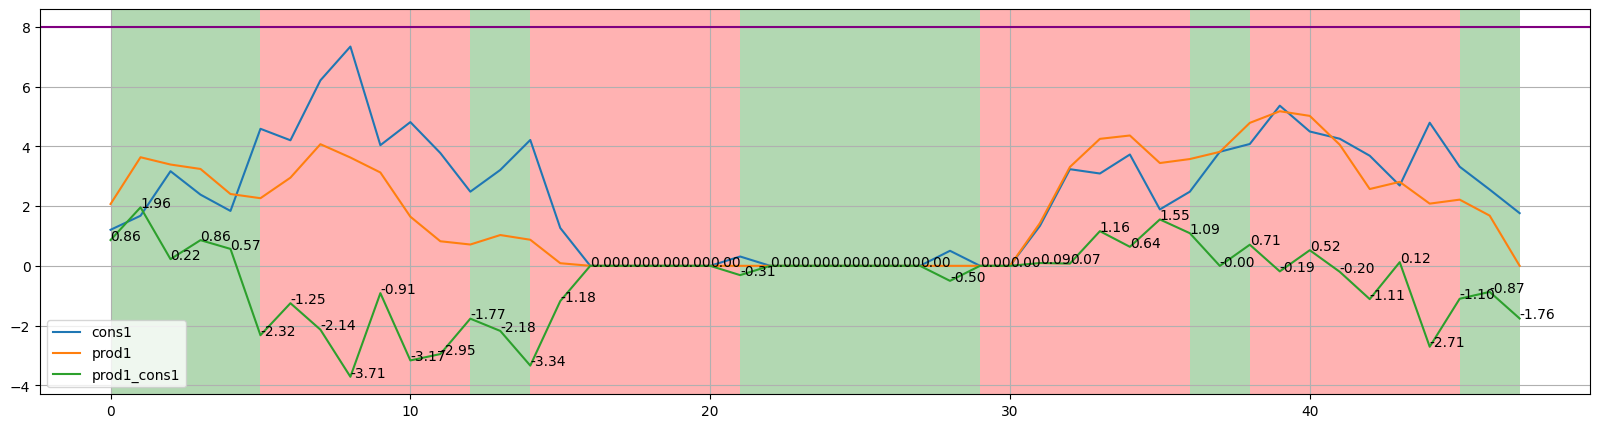

<Figure size 2000x500 with 0 Axes>

In [7]:

'''
- nie mamy wpływu na maksymalny output pradu z bateri, batteria powinna byc tak zadesignowana ze przy kazdym stanie naladowania jest wstanie dać zmamionowy maksymalny prad pracy 
[założenie] jesteśmy staratni w 100% jak nie wykozystamy energi tej "sprzedanej"
[założenie] całkowanie pod effi batteri(effi jest podane dyskretnie wiec takie całkowanie jest przybliżeniem)
[załozenie] moze mieć nadmiar procukcji w 'high' i pełną baterie z preloadowania w low( ale to nie jest wielka strata)

rozmnożenie mocy poprzez sprezdnie jak cena jest wysoka zeby odzyskac kiedy indziej
'''
#faktyczne dane jakie bedziemy mieli
currPowerIn = 1     #waty z ostatniej sekundy -> mozna przeliczyc na ampery P = UI
currPowerOut =1     #waty z ostatniej sekundy -> mozna przeliczyc na ampery P = UI
predPowerIn =   {'time':[], 'value':[]}    #kWh
predPowerOut =  {'time':[], 'value':[]}    #kWh

eps = 0.000001 # float prec
#stale jakie mozna podac/tweakować
timeInterval = 3 # hours of agregation / predyction

priceLow = 0.3672           #na kWh     ceny z PGE czerwiec 2023 file:///C:/Users/Jakub/Downloads/Tabela-cen-dla-energii-elektrycznej-dla-Klientow-z-segmentu-gospodarstw-domowych-w-2023-r.pdf 
priceHigh = 0.5803           #na kWh    ceny z PGE czerwiec 2023 file:///C:/Users/Jakub/Downloads/Tabela-cen-dla-energii-elektrycznej-dla-Klientow-z-segmentu-gospodarstw-domowych-w-2023-r.pdf 
priceSell = [0.41292,0.38987,0.40700,0.42073,0.43173,0.43739,0.53262,0.57539,0.54775,0.48169,0.40844,0.38840,0.40138,0.42708,0.46684,0.47192,0.46555,0.52259,0.61014,0.64013,0.65031,0.57184,0.52114,0.46162]    #za kWh w godianch z PSE z https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce
timeLow  = [1,2,3,4,5,13,14,22,23,24]
money = Money(priceLow,priceHigh,0.8585, 0.8585, timeLow,priceSell,0,2000)

battStartCharge = 0     #waty
battMaxCapacity = 8   #waty
battMaxCurrenIn = 1     #ampery
battVoltIn = 3         #volt
battMaxCurrenOut = 1    #ampery
battVoltOut = 1        #volt
battEffiOut = 0.9       #procenty
battEffiIn = [0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.6]     #procenty, od procentu naładowania baterri
battery = Battery(battStartCharge,battMaxCapacity,battEffiIn,battEffiOut,battMaxCurrenIn,battMaxCurrenOut,battVoltIn,battVoltOut)



#zmienne pomocnicze 
battState = []
moneyState = []
balanceState = []
powerNeeded = []
batteryCurrentLoad = []

### =======================================Symulacja================================

predPowerIn['value'] = prod1
predPowerOut['value'] = cons1

for i in range(len(predPowerIn['value'])):
    time = i % 24 + 1
    predPowerIn['time'].append(time)
    predPowerOut['time'].append(time)

for i,powerIn in enumerate(predPowerIn['value']):
    time = predPowerIn['time'][i]
    powerOut = predPowerOut['value'][i]
    powerDiff = powerIn - powerOut
    powerNeeded.append(-min(0,powerDiff))

    powerDiff = battery.useBattery(powerDiff,timeInterval)
    money.UseGrid(powerDiff,time)

    
    battState.append(battery.chargeCurrent)
    moneyState.append(money.currMoney)
    balanceState.append(money.currSellBalance)
batteryCurrentLoad = [0] + list(np.diff(battState))

print(-money.currMoney)
##===========================Optim power in red=============================

powerNeededInBattery = [0]*len(powerNeeded)
pointsOfIntrest = []

sumInRed = 0
for t,p in reversed(list(enumerate(powerNeeded))):
    currentStateIsHigh = money.IsTimeHigh(t%24 + 1)
    if currentStateIsHigh:
        sumInRed += min(p,battery.powerOutMax*timeInterval)
    else:
        if sumInRed != 0:
            pointsOfIntrest.append(t+1)
        sumInRed = 0
    powerNeededInBattery[t] = sumInRed

print(pointsOfIntrest)

chargingPowerToBattery = [0]*len(powerNeeded)
##############################TODO BEtter wziąć pod uwage stan anłądowania baterri jak i to ile w nia wchodzi w kolejnych krokach 
for i in pointsOfIntrest:
    power = min(battery.chargeMax*battery.maxProfitChargeLvl(money), powerNeededInBattery[i])
    #power -= battState[i]
    power = battery.powerRequiredToGetToLVLFrom(battState[i],power)

    j = 0
    battLoading = np.maximum([0] + list( np.diff(battState)),0)
    while power > 0 and i - j - 1 >= 0:
        
        power -= battState[i - j - 1]
        powerDischargingBattery = -min(0,batteryCurrentLoad[i - j - 1]) # only negative changes (dischaging), flip so it is positive
        charge = min(battery.powerInMax*timeInterval,battery.powerOutMax*timeInterval - powerDischargingBattery ,power) # future power taken from battery cant excede maxDischarge, so calculate how much more can battery give, and cant charge over charging limit
        if money.IsTimeLow((i - j - 1) % 24 + 1): # charge only in green
            chargingPowerToBattery[i - j - 1] = charge
            power -= charge
        j += 1

##check if not over battcapacity in any single moment
# make actual battery state after charging, then check where it exceds max and adjust 
        ## load only in green time
 #TODO   ## battCharge Effi calculations
        ## effi on taking from batt / putitng tu batt
        ## preload for selling if capacity 
#===============Sim with taking power from grid in low=============================
battery.reset()
money.reset()

battStateOpt1 = []
moneyStateOpt1 = []
balanceStateOpt1 = []
powerNeededOp1 = []
powerSold = []
for i,powerIn in enumerate(predPowerIn['value']):
    time = predPowerIn['time'][i]
    powerOut = predPowerOut['value'][i]
    powerDiff = powerIn - powerOut 
    powerNeededOp1.append(-min(0,powerDiff))

    if chargingPowerToBattery[i] > 0 and powerDiff < 0: #we have powerdeficyt in future high, and now we need power so dont take int from battery
        money.UseGrid(powerDiff,time)
        print(f'buy p:{powerDiff}, i:{i}')
    else:                                               # else use power from battery
        powerDiff = battery.useBattery(powerDiff,timeInterval)
        if powerDiff > 0:
            powerSold.append(powerDiff)
        else:
            powerSold.append(0)
        money.UseGrid(powerDiff,time)

    powerDiff = battery.useBattery(chargingPowerToBattery[i],timeInterval)
    if powerDiff + eps < 0 < powerDiff - eps:
        print(f'[Error] trying to preload battery with invalid power: bat{battery.chargeCurrent}, charging: {chargingPowerToBattery[i]}, diff: {powerDiff}, t:{timeInterval}, i:{i}')
    money.UseGrid(-chargingPowerToBattery[i],time)

    battStateOpt1.append(battery.chargeCurrent)
    moneyStateOpt1.append(money.currMoney)
    balanceStateOpt1.append(money.currSellBalance)
batteryCurrentLoadOpt1 = [0] + list(np.diff(battStateOpt1))

# battAfterCharge = []
# i = 0
# for e in reversed(pointsOfIntrest):
#     s = 0
#     while i <= e:
#         s += chargingPowerToBattery[i]
#         battAfterCharge.append(s + battState[i])
#     #    print(i, s, s + battState[i])
#         i += 1
# s = 0
# while i < len(battState):
#     s += chargingPowerToBattery[i]
#     battAfterCharge.append(s + battState[i])
#    # print(i, s, s + battState[i])
#     i += 1


##========================Ploting============================
# plt.plot(battState,'green')
# plt.plot(moneyState,'ro')
# plt.plot(balanceState,'blue')
# plt.plot(powerNeeded,'y')
# plt.plot(powerNeededInBattery,'o')
# plt.plot(chargingPowerToBattery,'o')
# plt.plot(battAfterCharge)
moneChange = [0] + list(np.diff(moneyStateOpt1))
plotPowerLines(
    battState=(battState,'green'), 
    battStateOpt1=(battStateOpt1,'',True),
    moneChange=(moneChange,''),
    powerSold=(powerSold,'-sc'),
    #moneyState=(moneyState,'ro'),
    #balanceState=(balanceState,'blue'),
    #)

#plotPowerLines(
    batteryCurrentLoad=(batteryCurrentLoad,''),
    powerNeeded=(powerNeeded,'y',True), 
    powerNeededInBattery=(powerNeededInBattery,'x'),
    chargingPowerToBattery=(chargingPowerToBattery,'o')
    #battAfterCharge=(battAfterCharge,'y')
    )

plotPowerLines(
    cons1=(cons1,''), 
    prod1=(prod1,''),
    prod1_cons1=(prod1-cons1,'',True))

print(-money.currMoney)

print(batteryCurrentLoad)
print(battery.maxProfitChargeLvl(money))
#18.273591118225692
#17.34158966424969

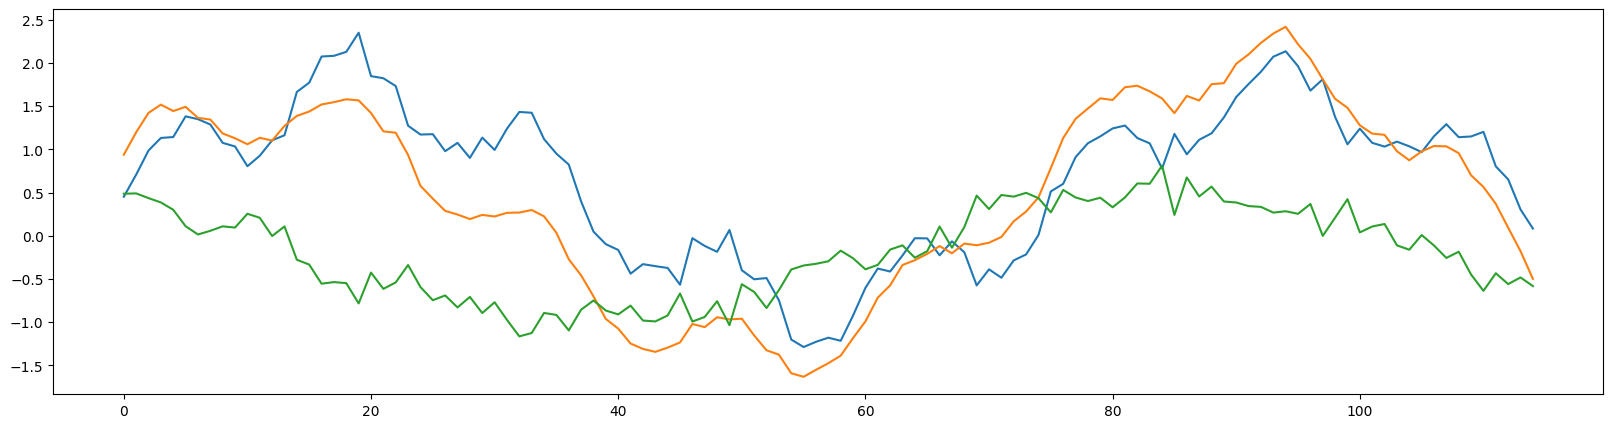

In [4]:
agregAmount = 5
cons,prod = batch(agregAmount,cons1,prod1,plot=True)

### Code Tests

In [50]:
#batery logic test
bat = Battery(0,100,[0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.6] ,0.9,1,10,30,1)
#bat = Battery(0,100,1 ,0.9,1,1,30,1)
bat.print()
# bat.chargeCurrent = 95
# print("ret:",bat.charge(1,3))
bat.print()
print("ret:",bat.charge(10,3))
bat.print()
print("ret:",bat.charge(80,1))
bat.print()
print("ret:",bat.charge(80,3))
bat.print()
print("ret:",bat.charge(1,3))
bat.print()
print("ret:",bat.charge(20,3))
bat.print()
print()
print("ret:",bat.discharge(10,3))
bat.print()
print("ret:",bat.discharge(80,1))
bat.print()
print("ret:",bat.discharge(80,3))
bat.print()
print("ret:",bat.discharge(1,3))
bat.print()


0 / 100; in:30 out:10; effi:0.81
0 / 100; in:30 out:10; effi:0.81
ret: 0
9.0 / 100; in:30 out:10; effi:0.81
ret: 50.0
36.0 / 100; in:30 out:10; effi:0.81
ret: 0.0
96.76190476190476 / 100; in:30 out:10; effi:0.54
ret: 0
97.36190476190475 / 100; in:30 out:10; effi:0.54
ret: 15.603174603174589
100 / 100; in:30 out:10; effi:0.54

ret: 0
88.88888888888889 / 100; in:30 out:10; effi:0.63
ret: 70
77.77777777777777 / 100; in:30 out:10; effi:0.7200000000000001
ret: 50
44.444444444444436 / 100; in:30 out:10; effi:0.7200000000000001
ret: 0
43.33333333333332 / 100; in:30 out:10; effi:0.7200000000000001


In [63]:
priceSell = [0.41292,0.38987,0.40700,0.42073,0.43173,0.43739,0.53262,0.57539,0.54775,0.48169,0.40844,0.38840,0.40138,0.42708,0.46684,0.47192,0.46555,0.52259,0.61014,0.64013,0.65031,0.57184,0.52114,0.46162]    #za kWh w godianch z PSE z https://www.pse.pl/dane-systemowe/funkcjonowanie-rb/raporty-dobowe-z-funkcjonowania-rb/podstawowe-wskazniki-cenowe-i-kosztowe/rynkowa-cena-energii-elektrycznej-rce
timeLow  = [1,2,3,4,5,13,14,22,23,24]
mon = Money(priceLow=0.3672,priceHigh=0.5803,priceOverLow=0.8585, priceOverHigh=0.8585, hoursLow=timeLow,priceSell=priceSell,powerUsedThisYear=0,powerPriceLimit=2000)
mon.UseGrid(10,1)
mon.print()
mon.UseGrid(-10,1)
mon.print()
mon.UseGrid(-100,2)
mon.print()
mon.UseGrid(50,3)
mon.print()

mon:0 bala:4.1292 usag:0
mon:0.0 bala:0.45719999999999983 usag:0.0
mon:-36.2628 bala:0.0 usag:98.75490196078431
mon:-36.2628 bala:20.349999999999998 usag:98.75490196078431


In [104]:
for i in range(1,25):
    print(i,mon.IsTimeLow(i))

1 True
2 True
3 True
4 True
5 True
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 True
14 True
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 True
23 True
24 True


In [45]:
battery = Battery(battStartCharge,battMaxCapacity,battEffiIn,battEffiOut,battMaxCurrenIn,battMaxCurrenOut,battVoltIn,battVoltOut)
print(battery.effiIn)
battery.chargeCurrent = 1.2
print(battery.powerRequiredToGetToLVL(8))
battery.chargeCurrent = 1
print(battery.powerRequiredToGetToLVL(6))
battery.chargeCurrent = 4
print(battery.powerRequiredToGetToLVL(1))
battery.chargeCurrent = 3
print(battery.powerRequiredToGetToLVL(3.5))
print(battery.effiOut)

battery.chargeCurrent = 3
print("P =",battery.powerDrainedToGetPower(1))
battery.chargeCurrent = 3
print("P =",battery.powerDrainedToGetPower(4))
battery.chargeCurrent = 8
print("P =",battery.powerDrainedToGetPower(7.5))
battery.chargeCurrent = 1
print("P =",battery.powerDrainedToGetPower(1))


battery.chargeCurrent = 1
print("C =",battery.powerChargedFromPower(1))
battery.chargeCurrent = 0
print("C =",battery.powerChargedFromPower(10))
battery.chargeCurrent = 4
print("C =",battery.powerChargedFromPower(10))
battery.chargeCurrent = 4
print(battery.powerRequiredToGetToLVL(8) + battery.powerChargedFromPower(10)[1])
battery.chargeCurrent = 7
print("C =",battery.powerChargedFromPower(1))
battery.chargeCurrent = 8
print("C =",battery.powerChargedFromPower(1))


[0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.6]
7.555555555555556
5.555555555555556
-3.749999999999999
0.5972222222222222
[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
P = (1.1111111111111112, 1)
[error] lvl higher then current charge
P = (3.0, 2.7)
P = (8.0, 7.199999999999999)
P = (1.0, 0.9)
C = (1.9, 0.0)
C = (7.98095238095238, 0.0)
C = (8, 4.523809523809524)
9.523809523809524
C = (7.628571428571428, 0.0)
C = (8, 1.0)


## Naive aproach

In [5]:
def naiveAproach(cons,prod,maxBatCap):
    l = len(prod)
    bat = [0]*(l+1)
    #grid = [0]*(l+1)
    #gridEx = [0]*(l+1)

    batChange = prod - cons

    for i in range(l):
        bat[i+1] = bat[i] + batChange[i]

        if bat[i+1] < 0:
            #grid[i+1] = -bat[i+1] 
            bat[i+1] = 0
        if bat[i+1] > maxBatCap:
            #gridEx[i+1] = bat[i+1] - maxBatCap
            bat[i+1] = maxBatCap

    optimX = np.diff(bat)
    return optimX        

32.934373449927335

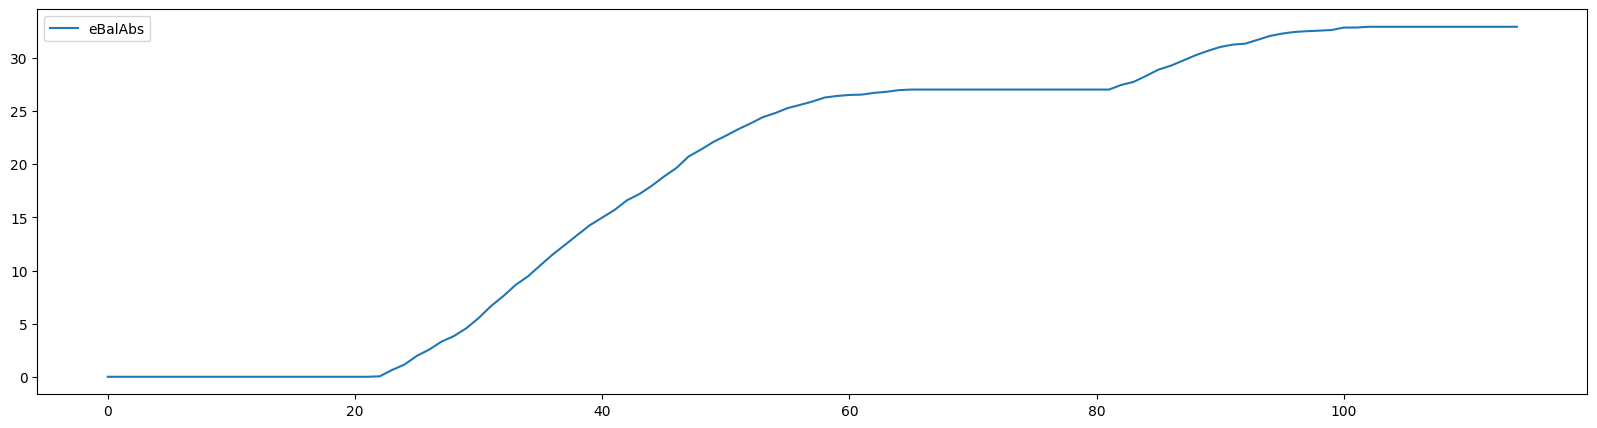

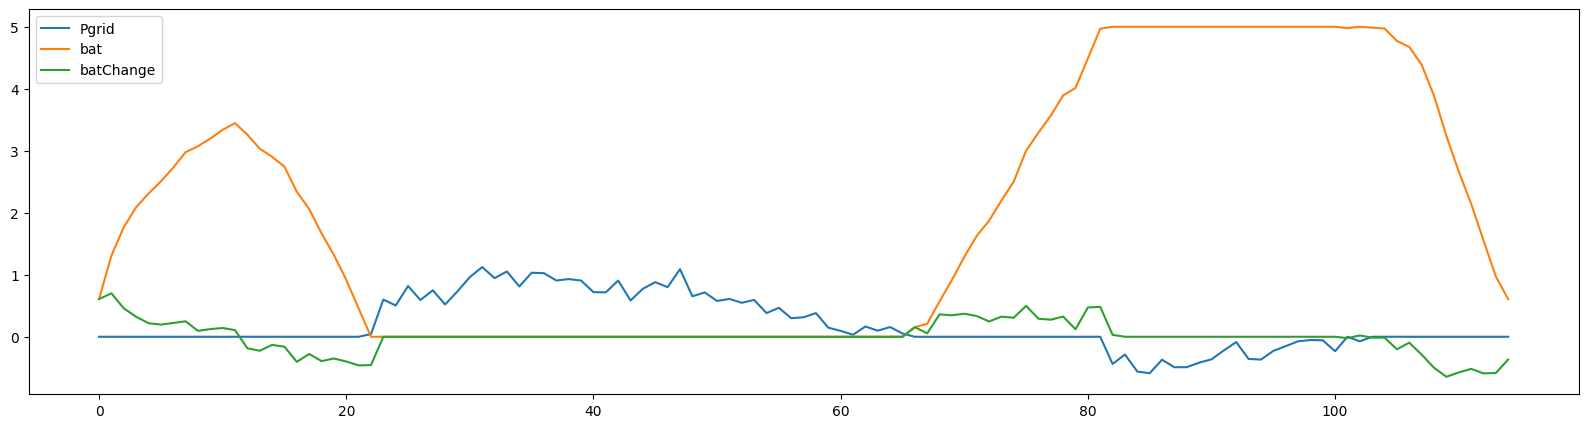

In [16]:
optimX = naiveAproach(cons,prod,maxBatCap=5)
fShow(optimX,cons,prod)

## Power Exchange Optimalization

In [7]:
def powerExchangeOptim(cons,prod,maxBatCap, maxBatChange):
    l = len(prod)
    x = cp.Variable(l)
    bal = cons - prod

    def f(batChange):
        eBalAbs =0
        for i in range(l):
            eBalAbs += cp.abs(bal[i] + batChange[i])
        return eBalAbs

    objective = cp.Minimize(f(x))
    constraints = [-maxBatChange <= x,
                    x <= maxBatChange,
                    cp.max(cp.cumsum(x)) <= maxBatCap,
                    cp.min(cp.cumsum(x)) >= 0]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    #print(x.value)
    #print(constraints[0].dual_value)
    return x.value


33.966603087959776

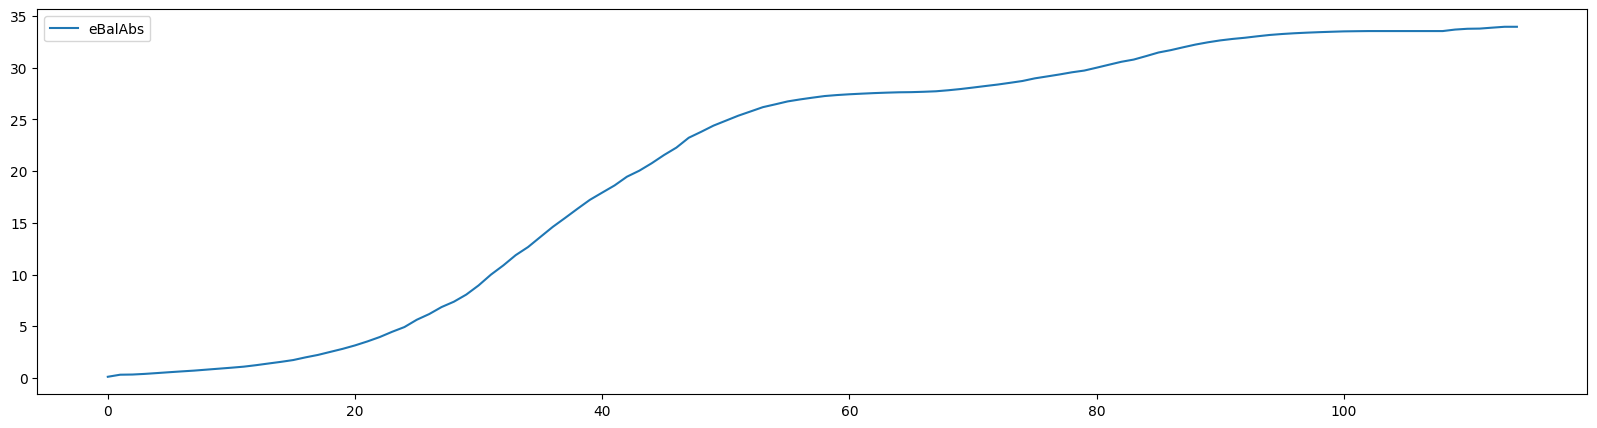

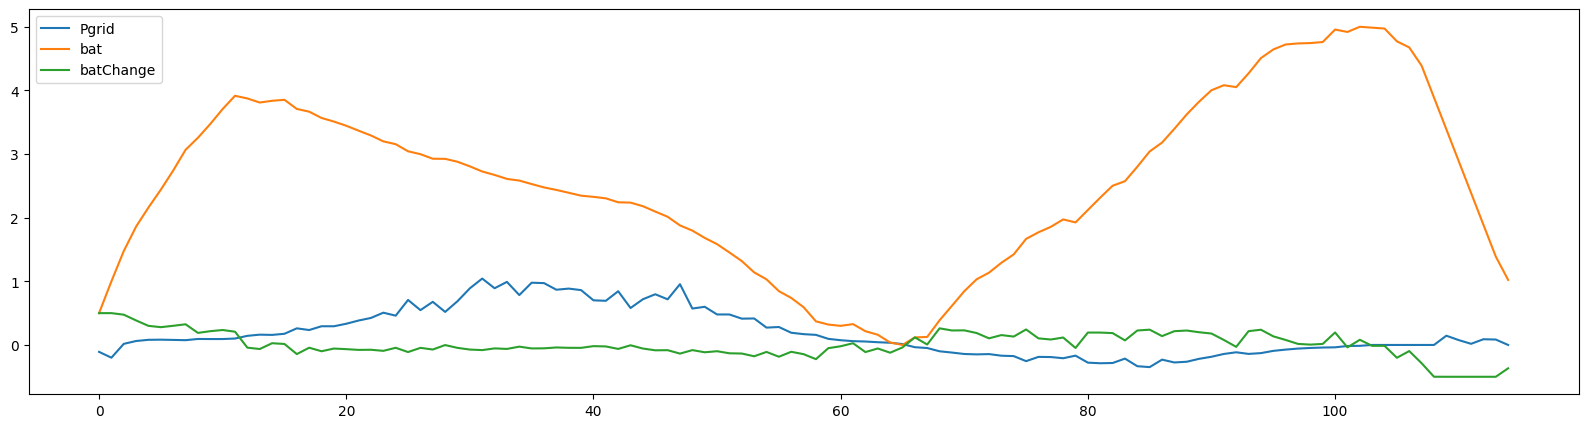

In [17]:
maxBatChange = 0.5
maxBatCap = 5
x = powerExchangeOptim(cons,prod,maxBatCap,maxBatChange)
fShow(x,cons,prod)

## Cost Optimalization

In [9]:
price = [0.5, 1]
def energyCost(i):
    i /= granulity
    i %= 24
    v = (0 <= i <=6) or (13 <= i <=15) or (22 <= i <= 24)
    return v*price[0] + (1-v)* price[1]

def energyCostNP(i):
    ii = i / granulity
    ii %= 24
    return np.where(((0<=ii) & (ii<=6)) | ((13<=ii) & (ii<=15)) | ((22<=ii) & (ii<=24)),price[0],price[1])

'''
def costOptimalization(cons, prod,maxBatCap, maxBatChange, energySellCoef, batChargCoef):
    l = len(prod)
    dis = cp.Variable(l)
    chg = cp.Variable(l)
    bal = cons - prod
    imp = np.maximum(bal,0)
    exp = -np.minimum(bal,0)

    def f(dis,chg):
        cost = 0
        for i in range(l):
            Pimp = imp[i] - dis[i]*batChargCoef
            Pexp = (exp[i] - chg[i])*energySellCoef
            cost += (Pimp - Pexp)*energyCost(i)/granulity*agregAmount
        return cost

    objective = cp.Minimize(f(dis,chg))
    constraints = [0 <= dis, dis <= maxBatChange,
                    0 <= chg, chg <= maxBatChange,
                    cp.min(imp - cp.cumsum(dis)*batChargCoef) >= 0,
                    cp.min(exp - cp.cumsum(chg)) >= 0,
                    cp.min(cp.cumsum(chg - dis)) >= 0,
                    cp.max(cp.cumsum(chg - dis)) <= maxBatCap]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    #print(x.value)
    #print(constraints[0].dual_value)
    return chg.value, dis.value  
'''
1

1

In [19]:
def costOptimalization(cons, prod,maxBatCap, maxBatChange, energySellCoef, batChargCoef):
    l = len(prod)
    dis = cp.Variable(l)
    chg = cp.Variable(l)
    bal = cons - prod
    imp = np.maximum(bal,0) #import do domu (+)
    exp = -np.minimum(bal,0) # export z domu nadwyzka produkcji (+)

    def f(dis,chg): # (+) (+)
        cost = 0
        for i in range(l):
            Pimp = imp[i] - dis[i] # optymalny import (+)
            Pexp = exp[i] - chg[i] # optylmany Export (+)
            cost += Pimp*energyCost(i)/granulity*agregAmount # optymalna import do domu * cena w tej godzinie
            cost -= Pexp*energyCost(i)/granulity*agregAmount*energySellCoef # optymalna export z domu * cena w tej godzinie * 0.8
        return cost

    objective = cp.Minimize(f(dis,chg))
    constraints = [0 <= dis, dis <= maxBatChange,
                    0 <= chg, chg <= maxBatChange,
                    (imp - dis) >= 0,
                    (exp - chg) >= 0,
                    cp.min(cp.cumsum(chg*batChargCoef - dis)) >= 0,
                    cp.max(cp.cumsum(chg*batChargCoef - dis)) <= maxBatCap]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    #print(x.value)
    #print(constraints[0].dual_value)
    return chg.value, dis.value

In [85]:
def f(x,y):
    return x + y
a = np.arange(10)
list(map(f,a,[10]*10))


[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

3.3441758054206296

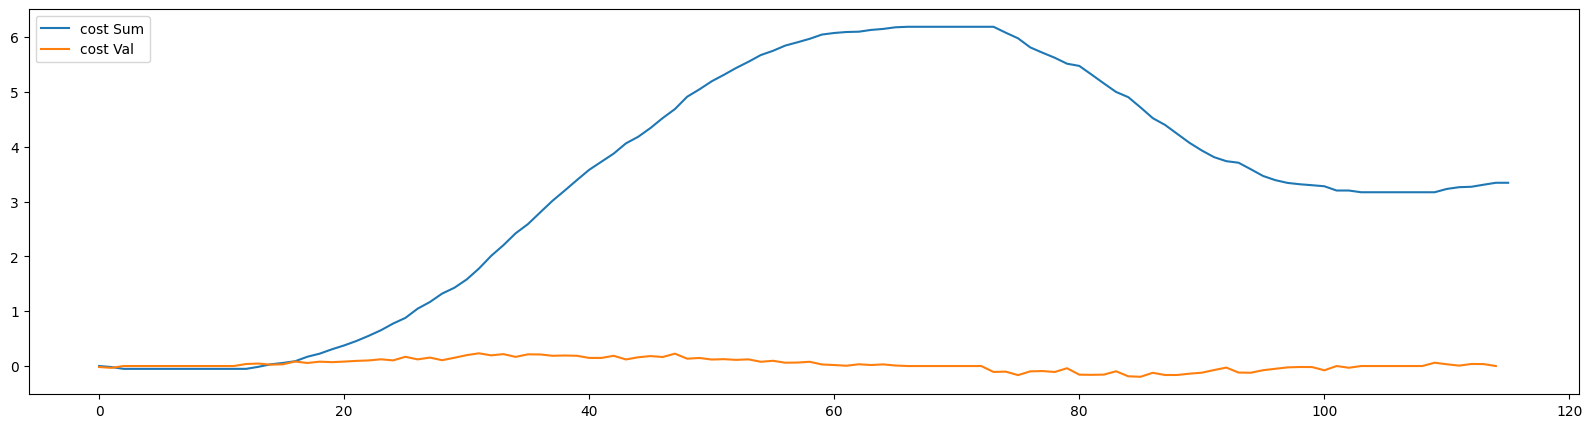

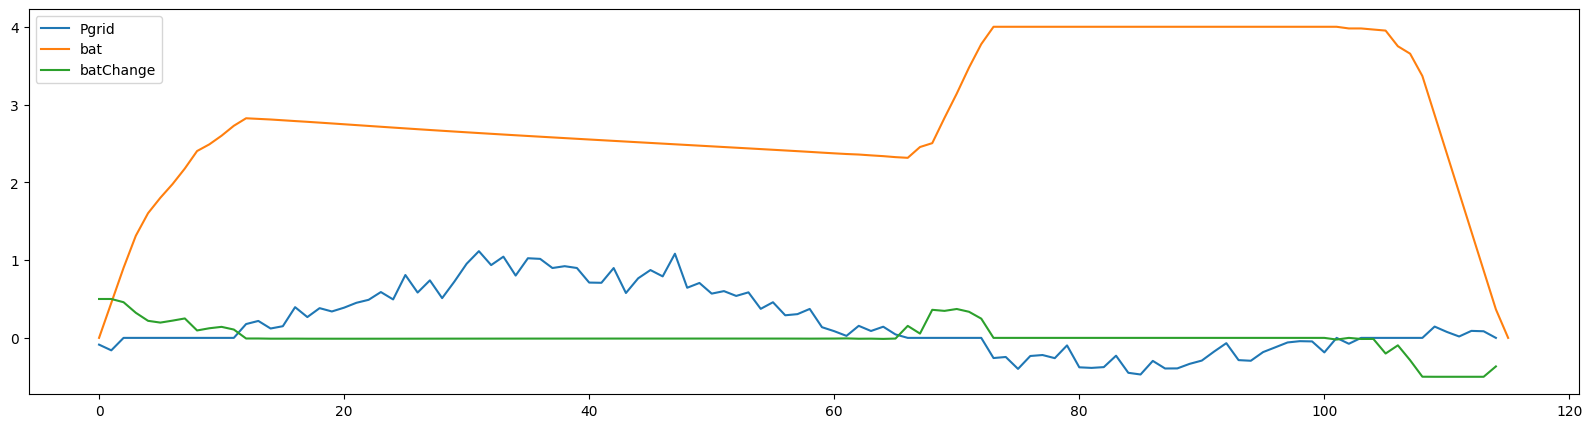

In [21]:
maxBatChange = 0.5
maxBatCap = 5
energySellCoef = 0.8
chg,dis = costOptimalization(cons,prod,maxBatCap,maxBatChange,energySellCoef,batChargCoef=0.9)
fCostShow(chg-dis,cons,prod,0.9)

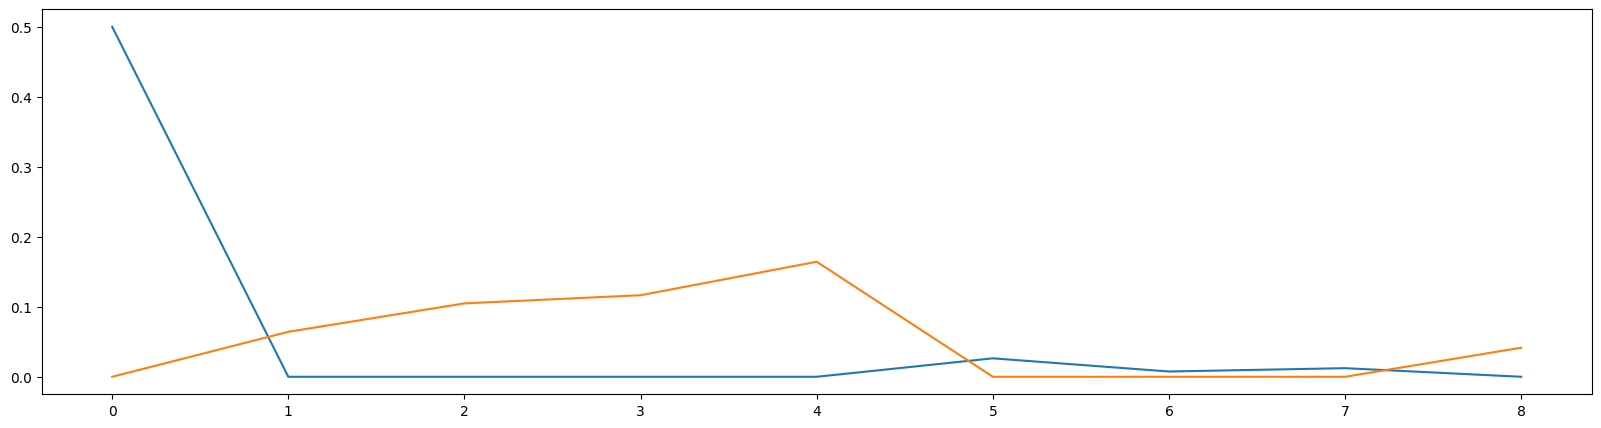

In [12]:
plt.plot(chg)
plt.plot(dis)

3.366819362914018

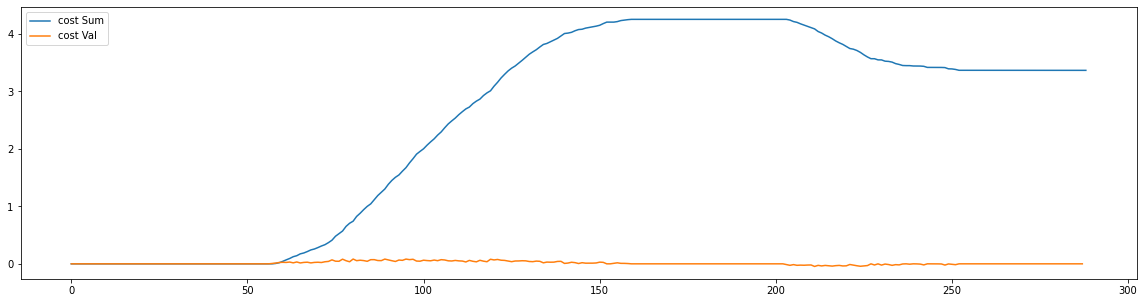

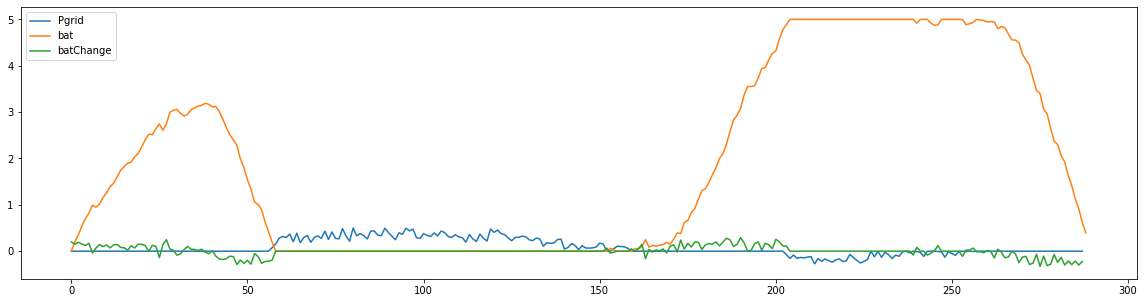

In [121]:
fCostShow(optimX,cons,prod)

## Test for agregation len

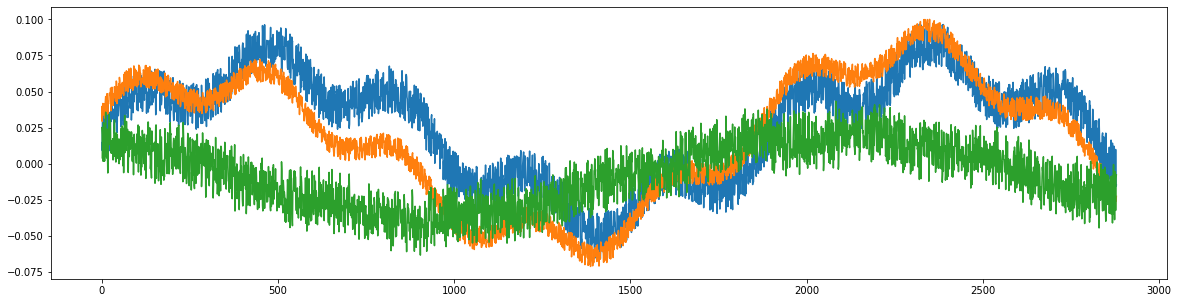

<Figure size 1440x360 with 0 Axes>

In [45]:
interval = 1 # in mins
lenght = 48 # lenght in hours
granulity = 60 / interval# per hour
batInit = 0
cons1, prod1 = generate(granulity,lenght,True)


In [156]:

xNaive = []; xAbsNaive = []
xOpitimzed = []; xAbsOptim = []
xCostOpt = []; xAbsCostOpt = []

maxBatChange = 0.5
maxBatCap = 5
energySellCoef = 0.8
chargeCoef = 0.9

agres = [1,2,3,6,12,24,30,40,50,60,70,80,90,100,110,120]
for i,agregAmount in enumerate(agres):
    cons,prod = batch(agregAmount,cons1,prod1)
    x = naiveAproach(cons,prod,maxBatCap)
    xNaive.append(x)
    xAbsNaive.append(fShow(x,cons,prod,False))
    progres_bar(i*3+1,len(agres)*3)

    x = powerExchangeOptim(cons,prod,maxBatCap,maxBatChange)
    xOpitimzed.append(x)
    xAbsOptim.append(fShow(x,cons,prod,False))
    progres_bar(i*3+2,len(agres)*3)

    chg,dis = costOptimalization(cons,prod,maxBatCap, maxBatChange, energySellCoef, chargeCoef)
    xCostOpt.append(chg-dis)
    xAbsCostOpt.append(fCostShow(xCostOpt[-1],cons,prod, chargeCoef,False))
    progres_bar(i*3+3,len(agres)*3)


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


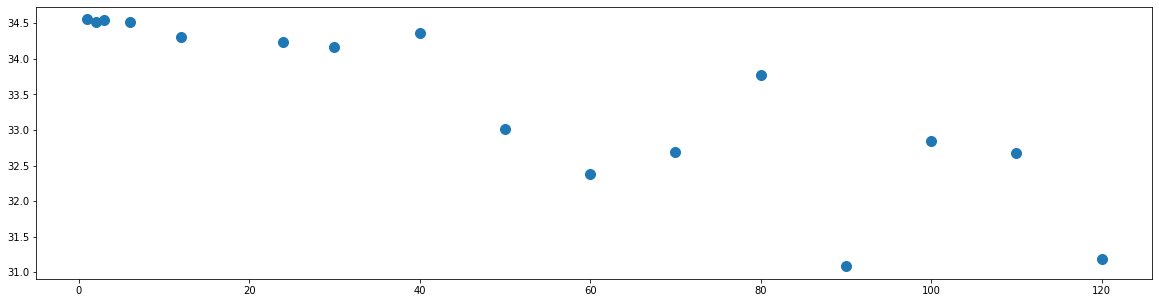

In [157]:
plt.plot(agres, xAbsNaive, "o", markersize=10)

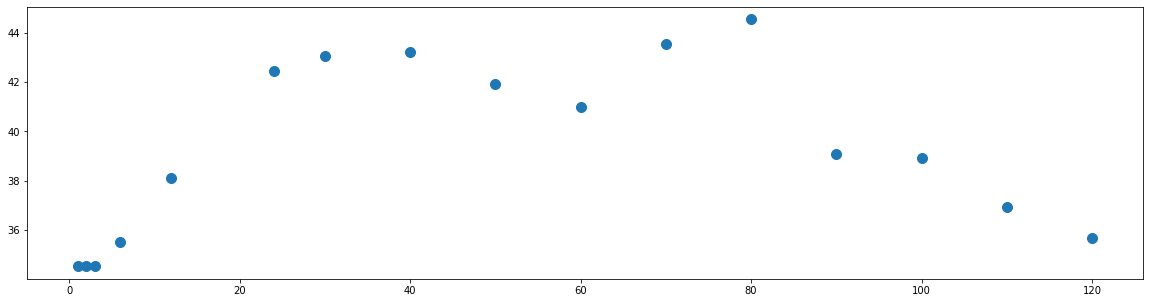

In [158]:
plt.plot(agres, xAbsOptim, "o", markersize=10)

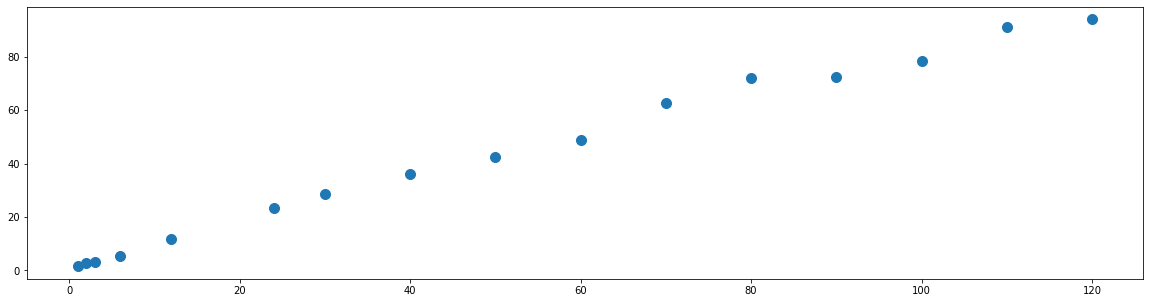

In [159]:

plt.plot(agres, xAbsCostOpt, "o", markersize=10)

In [14]:
import winsound
winsound.Beep(1000, 400)

## Other

In [192]:
bat = batInit - cons.cumsum() + prod.cumsum()

In [156]:
# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-1.79109255e-19  2.85112420e-02  2.79973443e-19  3.37658729e-20
 -2.72802663e-19  1.49285011e-01 -9.94082533e-20  8.35373900e-20
  2.46718649e-01  5.78224144e-01 -4.03739463e-19  1.01242860e-03
 -9.28486180e-20  2.26767464e-01 -1.58813678e-19 -8.97232272e-20
 -1.22145729e-19 -1.51509428e-19  1.12060672e-19 -3.48318635e-19]
[ 2.50938945  0.          2.78354615  1.79425782 13.08579183  0.
  0.73716363  3.35344995  0.          0.          8.93825054  0.
  7.02955161  0.          4.71068649  3.18873635  2.06090107 10.08166738
  3.0481157   8.53268239]


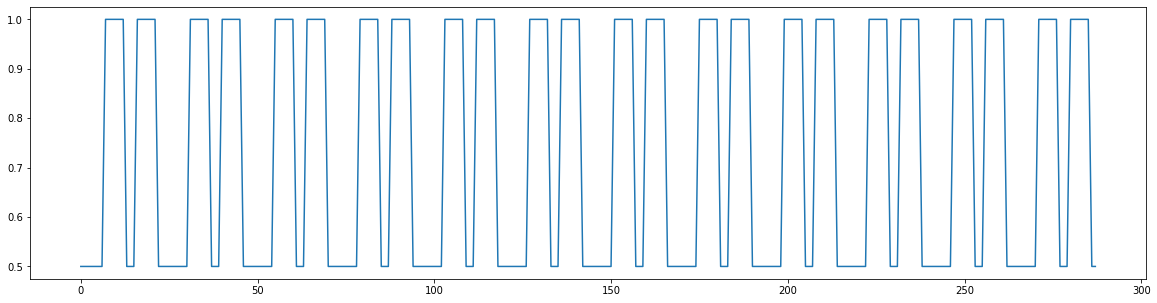

In [205]:
plt.plot(energyCostNP(np.arange(l)))

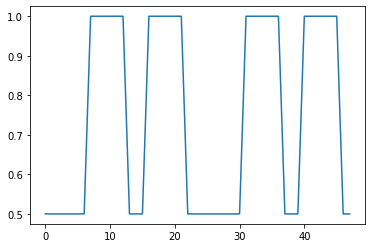

In [127]:
a = [0]*48
for i in range(48):
    a[i]=ePrice(i)
plt.plot(a)


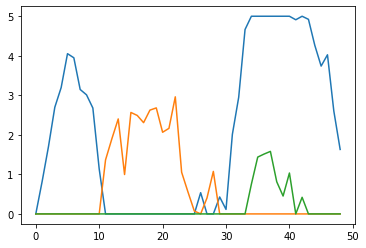

In [119]:
plt.plot(bat)
plt.plot(grid)
plt.plot(gridEx)

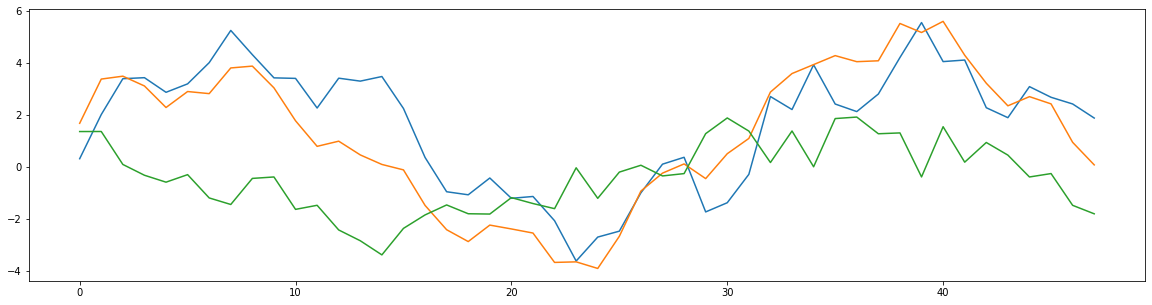

In [184]:
plt.plot(cons)
plt.plot(prod)
plt.plot(prod-cons)